In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
solar_power= pd.read_csv('solar_data.csv')

# Convert the Timestamp column to datetime
solar_power['Timestamp'] = pd.to_datetime(solar_power['Timestamp'], format='%d-%m-%Y %H:%M')
# Set Timestamp as index and sort it
solar_power= solar_power.set_index('Timestamp').sort_index()
solar_power['hour'] = solar_power.index.hour
solar_power['month'] = solar_power.index.month
solar_power['day'] = solar_power.index.day

solar_power.tail()


,Air_Temp,Relative_Humidity,Wind_Speed,Wind_Direction,Solar_Radiation,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,Array_Voltage,Array_Current,Power_Generated,hour,month,day
Timestamp,,,,,,,,,,,,,,,,
2022-04-29 01:00:00,16.580318,43.276824,0.0,49.674388,-0.243156,23.969398,25.226270,24.800780,24.674114,24.832156,2.833721,5.398601,15.298130,1,4,29
2022-04-29 01:02:00,16.336292,42.395772,0.0,348.423320,-0.344048,23.891640,25.166720,24.720160,24.610228,24.766238,2.840954,5.398601,15.337176,1,4,29
2022-04-29 01:04:00,16.226494,42.390788,0.0,43.298232,-0.446709,23.834920,25.131226,24.673068,24.576700,24.728590,2.841992,5.398601,15.342778,1,4,29
2022-04-29 01:06:00,16.157694,43.270232,0.0,218.255380,-0.496269,23.777128,25.095664,24.602908,24.529578,24.690848,2.839916,5.398421,15.331064,1,4,29
2022-04-29 01:08:00,16.222518,44.301432,0.0,210.405520,-0.496269,23.777128,25.081022,24.579838,24.539022,24.686726,2.831677,5.398421,15.286582,1,4,29


<Axes: xlabel='hour', ylabel='Power_Generated'>

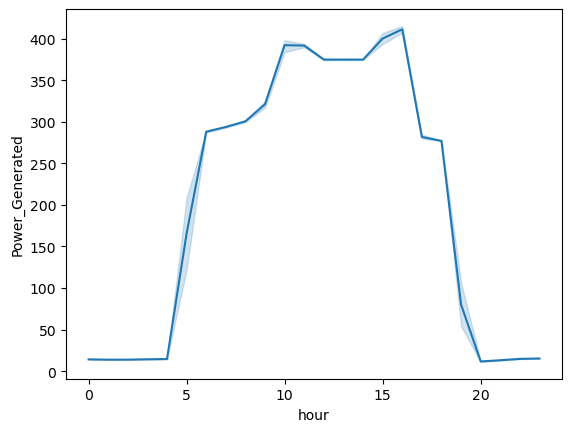

In [47]:
sns.lineplot(data=solar_power, x=solar_power.hour, y=solar_power.Power_Generated)

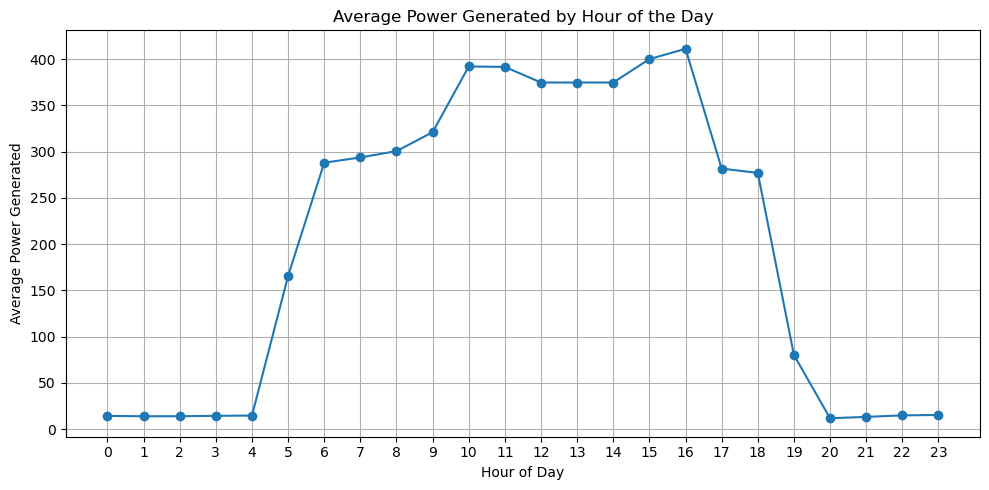

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Step 1: Extract hour and average power generated per hour
hourly_avg = solar_power.copy()
hourly_avg['hour'] = hourly_avg.index.hour
hourly_grouped = hourly_avg.groupby('hour')['Power_Generated'].mean()

# Step 2: Plot the hourly power generation pattern
plt.figure(figsize=(10, 5))
plt.plot(hourly_grouped.index, hourly_grouped.values, marker='o')
plt.title("Average Power Generated by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Power Generated")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

<Axes: xlabel='Timestamp', ylabel='Power_Generated'>

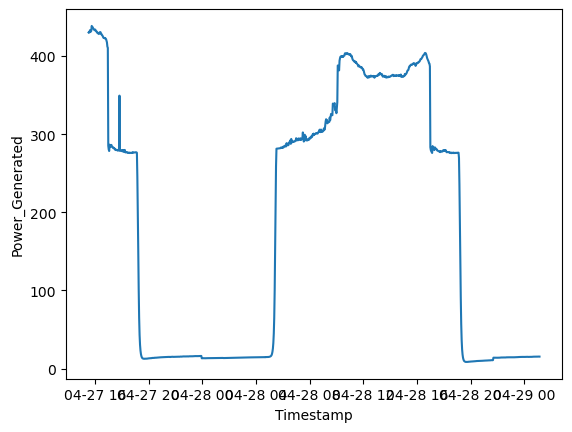

In [49]:
sns.lineplot(data=solar_power, x=solar_power.index, y=solar_power.Power_Generated)

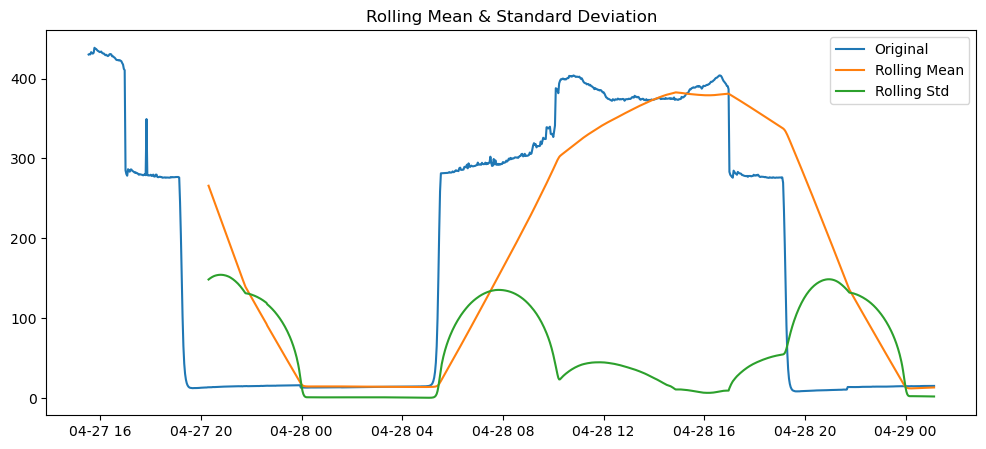

ADF Statistic: -1.7679
p-value: 0.3965


In [50]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

y=solar_power.Power_Generated
# 1. Rolling Mean & Std
rolling_mean = y.rolling(window=144).mean()  # one day if 10min intervals
rolling_std = y.rolling(window=144).std()

plt.figure(figsize=(12, 5))
plt.plot(y, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()

# 2. ADF Test
adf_result = adfuller(y.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


 If p-value ≥ 0.05 → Non-stationary i.e. mean and variance change over time (likely due to daily/seasonal cycles in solar radiation).
 Hence we have to make it stationary.

In [51]:
df=solar_power[['Power_Generated']]
df.head()

,Power_Generated
Timestamp,
2022-04-27 15:32:00,430.14572
2022-04-27 15:34:00,430.71452
2022-04-27 15:36:00,430.24568
2022-04-27 15:38:00,433.06504
2022-04-27 15:40:00,431.89576


In [52]:
#time shift
df['shift']=df.Power_Generated.shift()
df.head()

C:\Users\Pakhi Sharma\AppData\Local\Temp\ipykernel_26292\3642742529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df.Power_Generated.shift()


,Power_Generated,shift
Timestamp,,
2022-04-27 15:32:00,430.14572,NaN
2022-04-27 15:34:00,430.71452,430.14572
2022-04-27 15:36:00,430.24568,430.71452
2022-04-27 15:38:00,433.06504,430.24568
2022-04-27 15:40:00,431.89576,433.06504


In [53]:
df['shiftDiff']=df.Power_Generated - df['shift']
df.head()

C:\Users\Pakhi Sharma\AppData\Local\Temp\ipykernel_26292\1954095189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shiftDiff']=df.Power_Generated - df['shift']


,Power_Generated,shift,shiftDiff
Timestamp,,,
2022-04-27 15:32:00,430.14572,NaN,NaN
2022-04-27 15:34:00,430.71452,430.14572,0.56880
2022-04-27 15:36:00,430.24568,430.71452,-0.46884
2022-04-27 15:38:00,433.06504,430.24568,2.81936
2022-04-27 15:40:00,431.89576,433.06504,-1.16928


In [54]:

# Drop NaN (first row will have NaN after differencing)
diff_series = df['shiftDiff'].dropna()

# Perform ADF test
result = adfuller(diff_series)

# Display the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Number of lags used:", result[2])
print("Number of observations:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if result[1] < 0.05:
    print("\n=> The series is stationary (reject H0).")
else:
    print("\n=> The series is NOT stationary (fail to reject H0).")


ADF Statistic: -14.077141972766318
p-value: 2.8714231205635816e-26
Number of lags used: 1
Number of observations: 1006
Critical Values:
   1%: -3.436866962597422
   5%: -2.864417284603703
   10%: -2.5683020002450507

=> The series is stationary (reject H0).


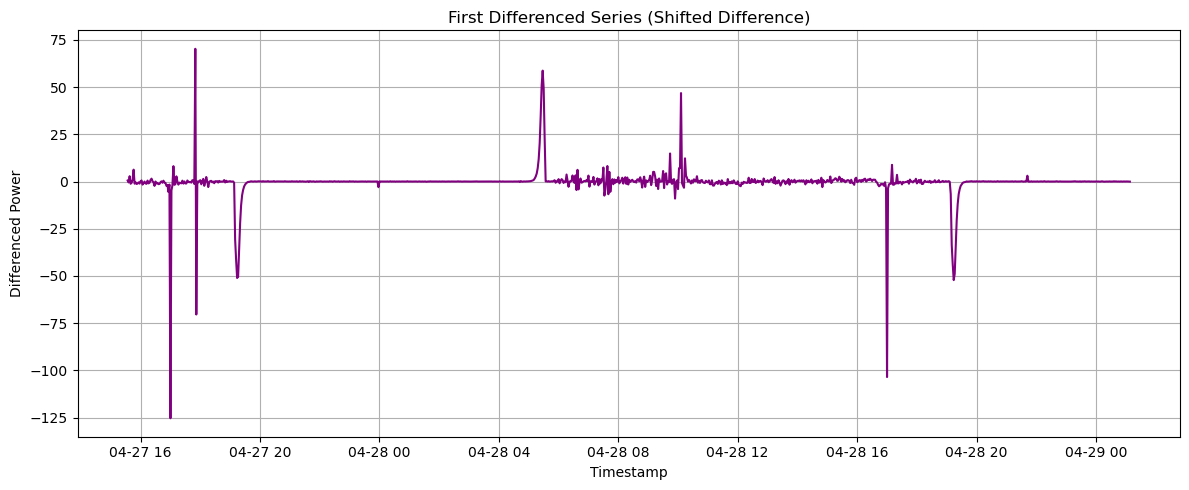

In [55]:

plt.figure(figsize=(12, 5))
plt.plot(diff_series, color='purple')
plt.title("First Differenced Series (Shifted Difference)")
plt.xlabel("Timestamp")
plt.ylabel("Differenced Power")
plt.grid(True)
plt.tight_layout()
plt.show()


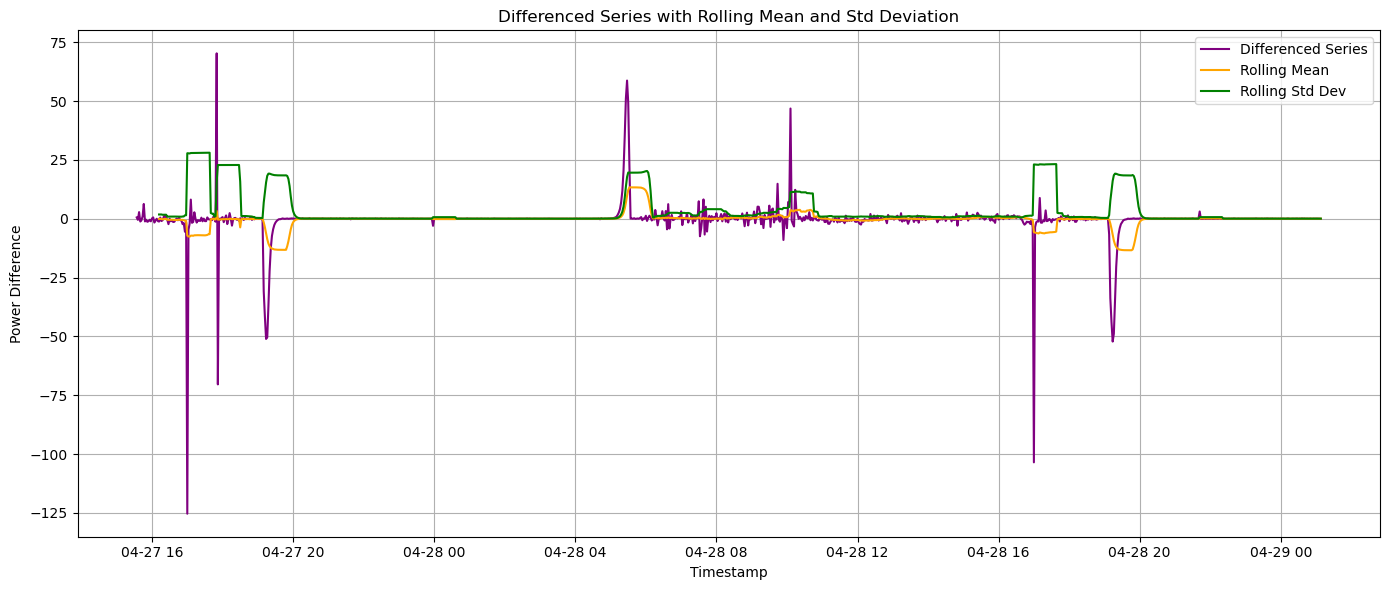

In [56]:

rolling_mean = diff_series.rolling(window=20).mean()
rolling_std = diff_series.rolling(window=20).std()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(diff_series, label='Differenced Series', color='purple')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title("Differenced Series with Rolling Mean and Std Deviation")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Differencing has reduced trend and seasonality, and the mean and variance are largely stable, which aligns with the requirements for weak stationarity. Once stationary, plot ACF and PACF to decide on:
p (AR terms) → PACF
q (MA terms) → ACF
d - It is the number of times the series needs to be differenced here, d=1

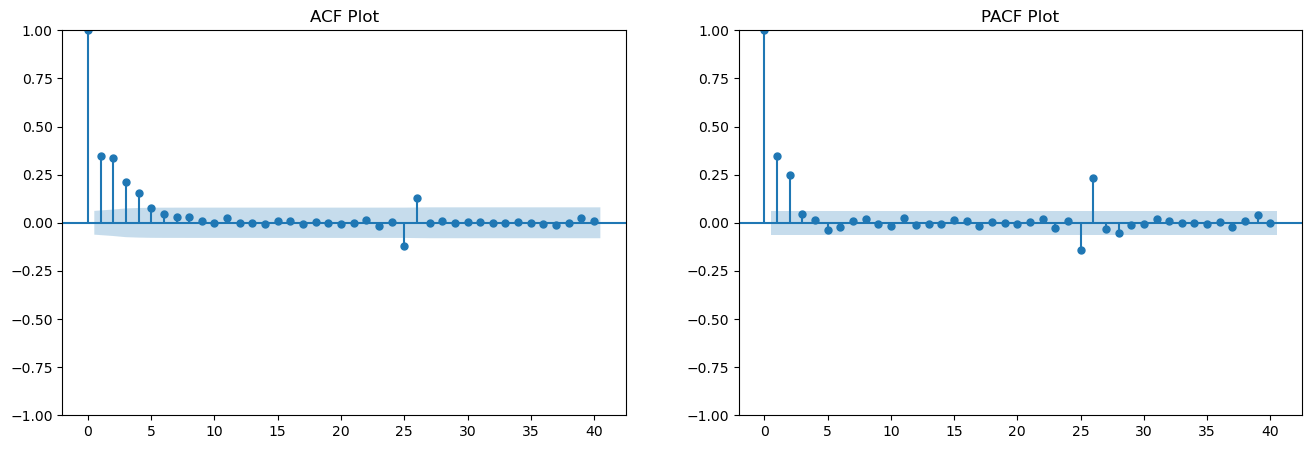

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_series, lags=40, ax=axes[0])
axes[0].set_title('ACF Plot')
plot_pacf(diff_series, lags=40, ax=axes[1])
axes[1].set_title('PACF Plot')
plt.show()

shaded area is insignificant area and unshade is significant area. Point exceeding to the shaded area take as p or q.
Here, p,q = 1 as 0th point is out of unshaded area then 1st pointin both PACF and ACF are excedding out of shaded area.
d=1 as differencing done one time.

In [59]:
# Exogenous variables (features)
exog_features = ['Air_Temp', 'Solar_Radiation', 'day','hour', 'Relative_Humidity','Wind_Speed',	'Wind_Direction','Array_Voltage','Array_Current']
exog = solar_power[exog_features]
# Target variable (endogenous)
y = solar_power['Power_Generated']


Resample to 10-minute intervals and take the mean and Removes any rows where the result of resampling caused missing values.

In [60]:
solar_power_resampled = solar_power.resample('10min').mean().dropna()

train_size = int(len(solar_power) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 1, 1),       # ARIMA(p,d,q) 
    seasonal_order=(1, 1, 1, 144),  # (P,D,Q,s), here s=144 for for daily seasonality (144 x 10min = 24 hours)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = model.fit(disp=False)
forecast = sarimax_result.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
r2 = r2_score(y_test, forecast)

print(f"SARIMAX Results: R2 = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}")

c:\Users\Pakhi Sharma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)
c:\Users\Pakhi Sharma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)


SARIMAX Results: R2 = 1.000, MAE = 0.672, RMSE = 0.780


In [61]:
df['SARIMAX']= forecast
df.tail()

C:\Users\Pakhi Sharma\AppData\Local\Temp\ipykernel_26292\3659868613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SARIMAX']= forecast


,Power_Generated,shift,shiftDiff,SARIMAX
Timestamp,,,,
2022-04-29 01:00:00,15.298130,15.253388,0.044742,16.359258
2022-04-29 01:02:00,15.337176,15.298130,0.039046,16.383732
2022-04-29 01:04:00,15.342778,15.337176,0.005602,16.397289
2022-04-29 01:06:00,15.331064,15.342778,-0.011714,16.357682
2022-04-29 01:08:00,15.286582,15.331064,-0.044482,16.319039


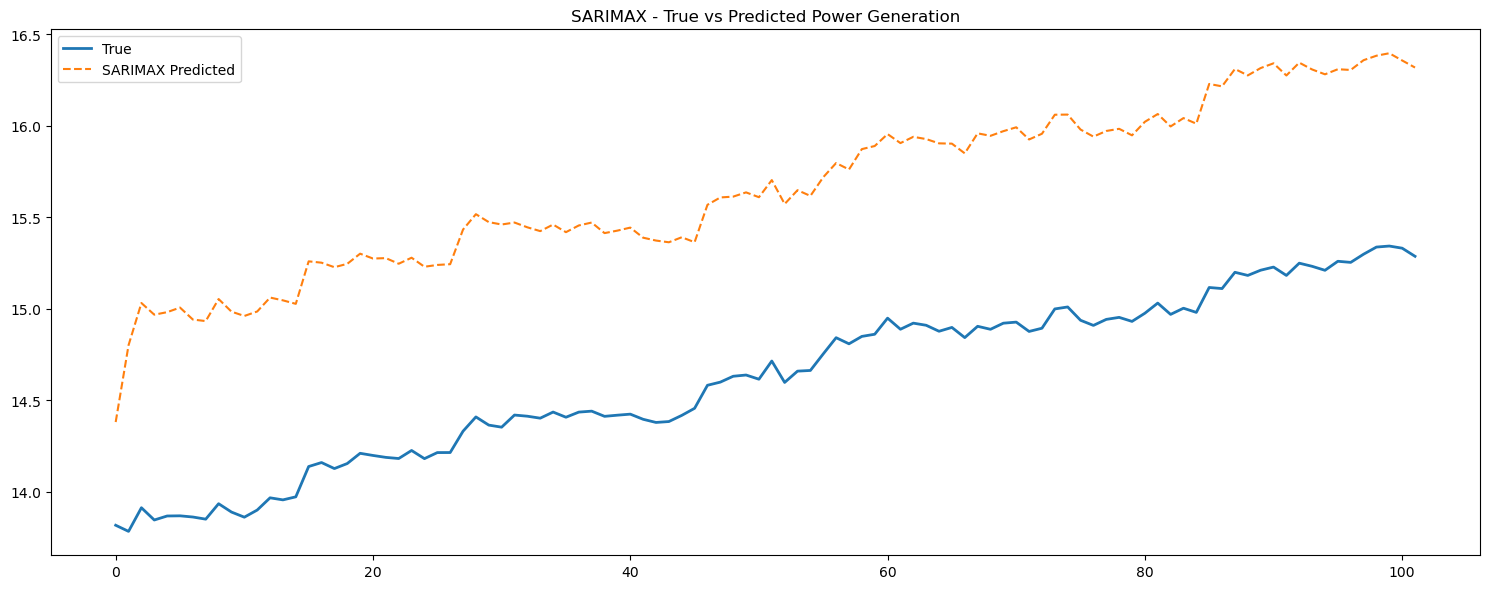

In [68]:

plt.figure(figsize=(15, 6))
plt.plot(y_test.values[100:], label="True", linewidth=2)
plt.plot(forecast.values[100:], label="SARIMAX Predicted", linestyle='--')
plt.title("SARIMAX - True vs Predicted Power Generation")
plt.legend()
plt.tight_layout()
plt.show()

FOR FUTURE PREDICTIONS

In [63]:
# Create a future datetime index (every 10 minutes for 5 days)
future_dates = pd.date_range(start=solar_power.index[-1] + pd.Timedelta(minutes=10), periods=720, freq='10min')
print(pd.DataFrame(future_dates[:5], columns=["FutureTimestamps"]))

     FutureTimestamps
0 2022-04-29 01:18:00
1 2022-04-29 01:28:00
2 2022-04-29 01:38:00
3 2022-04-29 01:48:00
4 2022-04-29 01:58:00


In [74]:
y_small = y[-7 * 144:]

model = SARIMAX(
    y_small,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 55)
)
sarimax_result = model.fit(disp=False, low_memory=True)

forecast_values = sarimax_result.forecast(steps=len(future_dates))

forecast_df = pd.DataFrame({
    'timestamp': future_dates,
    'forecast': forecast_values
})
print(forecast_df.head())


c:\Users\Pakhi Sharma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)
c:\Users\Pakhi Sharma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)


                              timestamp   forecast
2022-04-29 01:10:00 2022-04-29 01:18:00  15.239074
2022-04-29 01:12:00 2022-04-29 01:28:00  15.377735
2022-04-29 01:14:00 2022-04-29 01:38:00  15.521948
2022-04-29 01:16:00 2022-04-29 01:48:00  15.513472
2022-04-29 01:18:00 2022-04-29 01:58:00  15.770843


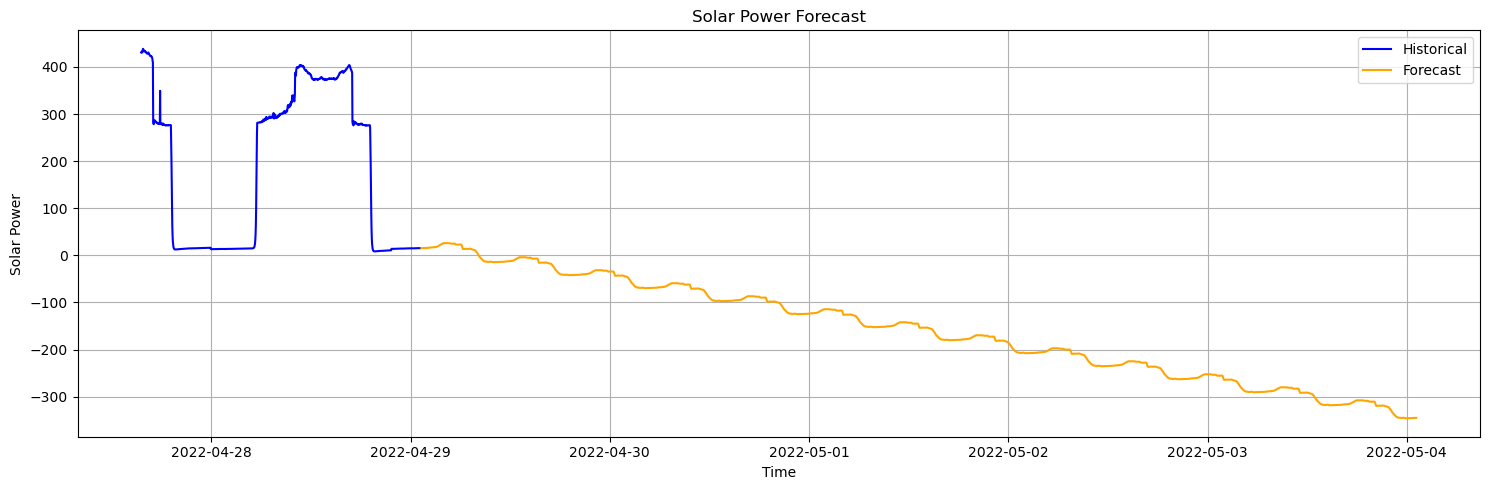

In [75]:
plt.figure(figsize=(15, 5))
plt.plot(y_small.index, y_small, label='Historical', color='blue')

# Plot forecasted data
plt.plot(forecast_df['timestamp'], forecast_df['forecast'], label='Forecast', color='orange')

# Formatting
plt.xlabel('Time')
plt.ylabel('Solar Power')
plt.title('Solar Power Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()